<a href="https://colab.research.google.com/github/taguchikarin/karin/blob/main/05_Flask_4_with_Form_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC_%E7%94%B0%E5%8F%A3%E8%8A%B1%E9%88%B4%EF%BC%BF2024214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title #1.　ngrokのauth_tokeを設定して前回の内容を実行[事前準備、設定]
# 1,2 Flask, pyngrokのインストール
!pip install flask pyngrok
#  必要なモジュールのimport
import os
# flaskからFlaskクラスをインポート
from flask import Flask
# pyngrokからngrokモジュールとconfモジュールをインポート
from pyngrok import ngrok, conf
# 設定
# ngrokトークンを設定
conf.get_default().auth_token = "2lrg1zBeYpmCIJwAxh39EDzZeQr_7Uneh1c3xXBKbJfURSxq5" #ここに自分のNgrokトークンを入れてください！！！！！

# Googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#@title #2.データベースとデータの中身を用意する
import sqlite3


# データベースのテーブル（データを入れるための形のある箱）を用意する
conn = sqlite3.connect('sample_db.sqlite')
cursor = conn.cursor()
cursor.execute('''
CREATE TABLE blogs (
    id INTEGER PRIMARY KEY,
    title TEXT NOT NULL,
    body TEXT NOT NULL,
    user_name TEXT NOT NULL,
    created_at TEXT NOT NULL DEFAULT (CURRENT_TIMESTAMP)
)
''')

conn.commit()
conn.close()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. テンプレートの更新

# 3-1. drive/My Drive/flask_blog/templates/home.htmlを更新

```
<!DOCTYPE html>
<html>
  <link rel="stylesheet" href="{{ url_for('static', filename='css/style.css')}}">
<head>
</head>
<body>
    <header>
      <h1>ミニブログをつくってみよう !</h1>
    </header>
    <a href="{{ url_for('blog_index')}}">ブログ</a>
</body>
</html>
```


# 3-2. drive/My Drive/flask_blog/templates/blogs.htmlを作成

新しくファイルを作ります

```


<!DOCTYPE html>
<html>
  <link rel="stylesheet" href="{{ url_for('static', filename='css/style.css')}}">
<head>
</head>
<body>
    <header>
      <h1>ミニブログを作ってみよう</h1>
    </header>
    <div>
    {% with messages = get_flashed_messages() %}
      {% if messages %}
      <ul class=flashes>
      {% for message in messages %}
        <li>{{ message }}</li>
      {% endfor %}
       </ul>
       {% endif %}
     {% endwith %}
    </div>
    <div>
    <form
    action="{{url_for('blog_create')}}"
    method="POST"
    novalidate="novalidate"
  >
    <p>
      <label for="title">タイトル：</label><input type="text" name="title" />
    </p>
    <p>
      <label for="user_name">投稿者名：</label><input type="text" name="user_name" />
    </p>
    <p>
      <label for="body">内容：</label><textarea name="body" cols="40" rows="10"></textarea>
    </p>
    <p><button type="submit">送る</button></p>
  </form>

  </div>

  <div>
    <ul>
      {% for blog in blogs %} <!-- ループさせてそれぞれ要素を取り出す -->
      <li>{{ blog }}</li>
       {% endfor %}
    </ul>
  </div>
</body>
</html>
```





上の作業でフォルダ構成がこうなっていることを確認してください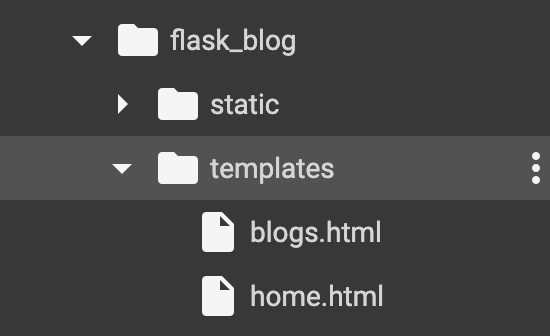

In [ ]:
#@title　#4.アプリケーションを初期化する/5.アプリケーションとデータベースを繋ぐための関数を用意する(前回と変わりなし)

from flask import g, render_template, redirect, url_for


# テンプレートと静的ファイルの置き場所を定数に代入
TEMPLATE_PATH = 'drive/My Drive/flask_blog/templates'
STATIC_PATH = 'drive/My Drive/flask_blog/static'
# Flaskのインスタンスを作るときにそれを利用してファイルパスを設定する
app = Flask(__name__, template_folder=TEMPLATE_PATH, static_folder=STATIC_PATH)


#@title　#5.アプリケーションとデータベースを繋ぐための関数を用意する

DATABASE = 'sample_db.sqlite'

def get_db():
    db = getattr(g, '_database', None)
    if db is None:
        db = g._database = sqlite3.connect(DATABASE)
    return db

@app.teardown_appcontext
def close_connection(exception):
    db = getattr(g, '_database', None)
    if db is not None:
        db.close()

def query_db(query, args=(), one=False):
    cur = get_db().execute(query, args)
    rv = cur.fetchall()
    cur.close()
    return (rv[0] if rv else None) if one else rv

def insert_or_delete_db(query, args=()):
    get_db().execute(query, args)
    get_db().commit()


In [ ]:
#@title #6.アプリケーションでデータを読み出す+テンプレートにデータを渡すプログラミング
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from flask import g, render_template, redirect, url_for, request, flash, session

#セッションを設定する
app.secret_key = 'timestamp'
app.permanent_session_lifetime = timedelta(days=5)
# /（ルート）にアクセスしたら次に書く関数(home)を実行するという宣言
@app.route("/")
def home():
    return render_template('home.html')

# /blogs にHTTPメソッドがGETでアクセスしたblog_index関数を実行する
@app.get("/blogs")
def blog_index():
   #データベースからデータを引き出す（配列の配列の形で帰ってくる）

    blogs = query_db("SELECT * FROM blogs")

    # テンプレートにblogs変数を渡す
    return render_template('blogs.html', blogs = blogs)

# /blogs にHTTPメソッドがPOSTでアクセスしたblog_create関数を実行する
@app.post("/blogs")
def blog_create():

    # フォームの値を取得してバリデーションを行う
    title = request.form["title"]
    user_name = request.form["user_name"]
    body = request.form["body"]

    is_valid = True
    if not title:
        flash("タイトルを入力してください。")
        is_valid = False

    if not user_name:
        flash("投稿者名を入力してください。")
        is_valid = False

    if not body:
        flash("本文を入力してください。")
        is_valid = False

    if not is_valid:
        return redirect(url_for("blog_index"))

    # データベースに挿入するためのSQLを組み立てる
    insert_sql =f"""
    INSERT INTO blogs (title, user_name, body)
    VALUES (?, ?, ?)
    """
    # SQL文を実行してデータを登録
    insert_or_delete_db(insert_sql, (title, user_name, body))


    # ルートにGETでリダイレクトする
    return redirect(url_for("blog_index"))


In [12]:
#@title #7.アプリケーションを立ち上げる

if __name__ == "__main__":
    public_url = ngrok.connect(5000)
    print(f"ngrok URL: {public_url}")
    app.run(port=5000)


ERROR:pyngrok.process.ngrok:t=2024-10-28T15:13:13+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2024-10-28T15:13:13+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok st

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n.